# Animation in Jupyter Notebooks

Animation features are built into the Python matplotlib library and available through Jupyter notebooks, but without robust documentation. This short notebook provides some simple demonstrations of using animiation for visualization of simulation results. The resulting animations are html video files embedded within the Jupyter notebook. The videos can be viewed in any modern web browser. Since they don't require an active Python kernal, the animations can be seen when the even when notebook is viewed as a static HTML web page.

The techniques used below come from blog postings [Animating the Lorenz System in 3D](https://jakevdp.github.io/blog/2013/02/16/animating-the-lorentz-system-in-3d/) and [Embedding Matplotlib Animations in Jupyter Notebooks](http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-notebooks/).

## Prerequisites

To create animiations using the following cells you will need to install a video codec on your laptop. By default matplotlib is configured to use ffmpeg.

## Step-by-Step Approach to Animation with Matplotlib

### Step 1. Create the background frame.

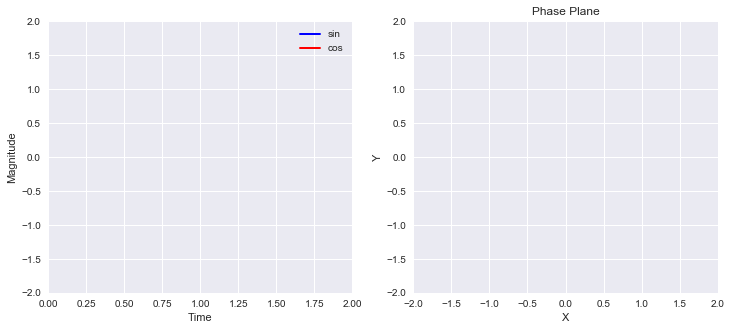

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# create a figure and axes
fig = plt.figure(figsize=(12,5))
ax1 = plt.subplot(1,2,1)   
ax2 = plt.subplot(1,2,2)

# set up the subplots as needed
ax1.set_xlim(( 0, 2))            
ax1.set_ylim((-2, 2))
ax1.set_xlabel('Time')
ax1.set_ylabel('Magnitude')

ax2.set_xlim((-2,2))
ax2.set_ylim((-2,2))
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_title('Phase Plane')

# create objects that will change in the animation
txt_title = ax1.set_title('')
line1, = ax1.plot([], [], 'b', lw=2)     # ax.plot returns a list of 2D line objects
line2, = ax1.plot([], [], 'r', lw=2)
pt1, = ax2.plot([], [], 'g.', ms=20)
line3, = ax2.plot([], [], 'y', lw=2)

ax1.legend(['sin','cos']);

### Step 2. Define a function to draw each frame

The animiation function is a function you define to draw individual frames in the animation.

In [2]:
# animation function. This is called sequentially
def drawframe(n):
    x = np.linspace(0, 2, 1000)
    y1 = np.sin(2 * np.pi * (x - 0.01 * n))
    y2 = np.cos(2 * np.pi * (x - 0.01 * n))
    line1.set_data(x, y1)
    line2.set_data(x, y2)
    line3.set_data(y1[0:50],y2[0:50])
    pt1.set_data(y1[0],y2[0])
    txt_title.set_text('Frame = {0:4d}'.format(n))
    return (line1,line2)

### Step 3. Create the Animation Object

The animation class includes a function `FuncAnimation` that incorporations a user-specified function to update the figure for each frame of the animation. The result is an animation object which is subsequently called to actually produce the desired animation.

In [3]:
from matplotlib import animation

# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=100, interval=20, blit=True)

### Step 4. Render the Animation

The final step is to actually render and display the desired animation. This is the compute-intensive step in the procedure. The next cell imports `HTML` which is used to display a HTML elements created in a python script. The animation is render to html5 video with the `to_html5_video()` function and then displayed with `HTML()`.

In [4]:
from IPython.display import HTML
HTML(anim.to_html5_video())

An alternative to the use of HTML is to set the default rendering of an animation object. 

In [5]:
from matplotlib import rc

# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')

Once the default rendering of the animation object is set to html5, all you have to do is ask to display the animation object. Everything is then done behind the scenes to render and display the desired animation.

In [6]:
anim

## Example: Phase Plane Animation for an Exothermic Stirred-Tank Reactor

In [104]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.integrate import odeint

from matplotlib import animation, rc
rc('animation', html='html5')


Ea  = 72750     # activation energy J/gmol
R   = 8.314     # gas constant J/gmol/K
k0  = 7.2e10    # Arrhenius rate constant 1/min
V   = 100.0     # Volume [L]
rho = 1000.0    # Density [g/L]
Cp  = 0.239     # Heat capacity [J/g/K]
dHr = -5.0e4    # Enthalpy of reaction [J/mol]
UA  = 5.0e4     # Heat transfer [J/min/K]
q = 100.0       # Flowrate [L/min]
cAi = 1.0       # Inlet feed concentration [mol/L]
Ti  = 350.0     # Inlet feed temperature [K]
cA0 = 0.5;      # Initial concentration [mol/L]
T0  = 350.0;    # Initial temperature [K]
Tc  = 300.0     # Coolant temperature [K]

# Arrhenius rate expression
def k(T):
    return k0*np.exp(-Ea/R/T)

def deriv(y,t):
    cA,T = y
    dcA = (q/V)*(cAi - cA) - k(T)*cA
    dT = (q/V)*(Ti - T) + (-dHr/rho/Cp)*k(T)*cA + (UA/V/rho/Cp)*(Tc-T)
    return [dcA,dT]

# choose cooling temperature
Tc = 305

# choose time grid
t = np.linspace(0,10.0,1000)

# create a set of initial conditions
ICs = []
ICs += [[cA0,T0] for cA0 in [0] for T0 in np.linspace(290,480,20)]
ICs += [[cA0,T0] for cA0 in np.linspace(0,1,21) for T0 in Tlist]
ICs += [[cA0,T0] for cA0 in [1] for T0 in np.linspace(290,480,20)]

# perform simulations
sols = [odeint(deriv,IC,t) for IC in ICs]

# create background figure and axes
sns.set(font_scale=2)
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlim((0,1))
ax.set_ylim((290,480))
ax.set_xlabel('Concentration [gmol/liter]')
ax.set_ylabel('Temperature [K]')
ax.set_title('Exothermic Reactor with Tc = {0:.1f} K'.format(Tc))

# create placeholders for points and trajectories
colors = sns.color_palette("husl",len(ICs))
pts = sum([ax.plot([],[],'o',color=colors[k],ms=15) for k in range(0,len(ICs))],[])
lines = sum([ax.plot([],[],color=colors[k],lw=2) for k in range(0,len(ICs))],[])

# don't show the plain background
plt.close()

# define function to draw each frame
def drawframe(n):
    for k in range(0,len(pts)):
        C,T = sols[k].T
        pts[k].set_data(C[n],T[n])
        lines[k].set_data(C[:n],T[:n])
    return pts + lines

# create simulation.  Assume default rendering will display as HTML
animation.FuncAnimation(fig, drawframe, frames=len(t), interval=20, blit=True)